In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from util import get_file_paths
from Vanilla_LSTM import Vanilla_LSTM


In [157]:

file_paths=get_file_paths("./data/valve1")

In [158]:
dfs=[]

for file_path in file_paths:
    df = pd.read_csv(file_path,sep=';',index_col='datetime', parse_dates=True)
    dfs.append(df)
    
# Concatenate all the DataFrames in the list into a single DataFrame
valve1_df = pd.concat(dfs) #, ignore_index=True)


In [159]:
def calc_metrics(y_true,y_pred):
  y_labels = np.where(y_pred>=0.5,1,0)
  accuracy = accuracy_score(y_true, y_labels)
  cm = confusion_matrix(y_true, y_labels)
  f1 = f1_score(y_true, y_labels)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  true_pos = cm[1, 1]
  true_neg = cm[0, 0]
  false_pos = cm[0, 1]
  false_neg = cm[1, 0]
  mar = false_neg / (false_neg + true_pos)
  far = false_pos / (false_pos + true_neg)

  return { 
    'accuracy': accuracy,
    'cm': cm,
    'f1': f1, 
    'far': far, 
    'mar': mar, 
    'fpr': fpr,
    'tpr': tpr, 
    'thresholds': thresholds, 
    'roc_auc': roc_auc 
}
 


In [160]:
# def plot_confusion_matrix(baseline, test):
#   return None

# def plot_roc_curve(baseline, test):
#   return None

def plot(baseline, test, title = 'Model Evaluation Metrics'):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
  fig.suptitle(title, fontsize=16, y=1.02)
  
  baseline_confusion_matrix_ax = ax[0]
  test_confusion_matrix_ax = ax[1]
  roc_curve_ax = ax[2]
  
  # Baseline Confusion Matrix in the first subplot
  ConfusionMatrixDisplay(confusion_matrix=baseline['cm']).plot(ax=baseline_confusion_matrix_ax)
  baseline_confusion_matrix_ax.set_title('Baseline Confusion Matrix')
  baseline_confusion_matrix_ax.set_xlabel('Predicted labels')
  baseline_confusion_matrix_ax.set_ylabel('True labels')

  # Test Confusion Matrix in the first subplot
  ConfusionMatrixDisplay(confusion_matrix=test['cm']).plot(ax=test_confusion_matrix_ax)
  test_confusion_matrix_ax.set_title('Test Confusion Matrix')
  test_confusion_matrix_ax.set_xlabel('Predicted labels')
  test_confusion_matrix_ax.set_ylabel('True labels')

  # ROC Curve in the second subplot
  roc_curve_ax.plot(baseline['fpr'], baseline['tpr'], color='green', lw=2, label=f"Baseline AUC = {baseline['roc_auc']:.2f}")
  roc_curve_ax.plot(test['fpr'], test['tpr'], color='darkorange', lw=2, label=f"Test AUC = {test['roc_auc']:.2f}")

  roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  roc_curve_ax.set_xlabel('False Positive Rate')
  roc_curve_ax.set_ylabel('True Positive Rate')
  roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
  roc_curve_ax.legend(loc='lower right')

  # Display the plot
  plt.tight_layout()
  plt.show()
  

In [161]:
def train_model(x_train, model, n):
    rows = x_train.shape[0]
    sample_size = rows // n
    sample_models = []
    for _ in range(n):
        # Bootstrap sample
        x_train_sample = x_train.sample(n=sample_size, random_state=_)
        X = x_train_sample.drop('anomaly', axis=1)
        y = x_train_sample['anomaly']
        # Fit model
        model_clone = clone(model)  # Clone the base model to avoid refitting the same model
        model_clone.fit(X, y)
        sample_models.append(model_clone)
    return sample_models

def test_models(x_test, models, operation_var):
    """
    Runs each model on the test data and calculates the probability of not being an anomaly.
    
    Parameters:
    - x_test: Features of the test data.
    - models: A list of trained models.
    - operation_var: Operation to perform on the probabilities ('max' or 'avg').
    
    Returns:
    - labels: The predicted labels for the test data.
    - test_not_anomaly_proba: The probability of not being an anomaly for each test sample.
    """
  
    probas = []
    for model in models:
        # Predict_proba returns [prob_anomaly, prob_not_anomaly] for binary classification
        
        anomaly_probs = model.predict_proba(x_test)
        prob_not_anomaly = anomaly_probs[:, 1]
        probas.append(prob_not_anomaly)

    probas = np.array(probas)

    # Calculate test_not_anomaly_proba based on operation_var
    if operation_var == 'max':
        test_not_anomaly_proba = np.max(probas, axis=0)
    elif operation_var == 'avg':
        test_not_anomaly_proba = np.mean(probas, axis=0)
    else:
        raise ValueError("operation_var must be 'max' or 'avg'")
    
    return test_not_anomaly_proba



total_rows = len(valve1_df)
index_70_percent = int(total_rows * 0.7)
index_90_percent = index_70_percent + int(total_rows * 0.2)

# Split the DataFrame into three parts
test_df = valve1_df.iloc[index_90_percent:] 
train_df = valve1_df.iloc[:index_70_percent]
valid_df = valve1_df.iloc[index_70_percent:index_90_percent]
print(f"Shape:\n Valve1 total: {valve1_df.shape}\nTrain (70%) {train_df.shape}\nValid (20%) {valid_df.shape}\nTest (10%) {test_df.shape}\n")

model = lgb.LGBMClassifier()  # Base LightGBM model


n = 10  # Number of models to train
sample_model_list = train_model(train_df, model, n=n)


#Baseline Data
X_valid = valid_df.drop('anomaly', axis=1)
y_valid= valid_df['anomaly']

# Test Data
max_valid_predict = test_models(X_valid, sample_model_list, operation_var='max')
avg_valid_predict = test_models(X_valid, sample_model_list, operation_var='avg')

X_test = test_df.drop('anomaly', axis=1)
y_test = test_df['anomaly']

# Test Data
max_test_predict = test_models(X_test, sample_model_list, operation_var='max')
avg_test_predict = test_models(X_test, sample_model_list, operation_var='avg')



Shape:
 Valve1 total: (18160, 10)
Train (70%) (12712, 10)
Valid (20%) (3632, 10)
Test (10%) (1816, 10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 440, number of negative: 831
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1271, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346184 -> initscore=-0.635855
[LightGBM] [Info] Start training from score -0.635855
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 429, number of negative: 842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

In [162]:
baseline_metrics = calc_metrics(y_valid,avg_valid_predict)
print(f"Baseline:\naccuracy {baseline_metrics['accuracy']:.2f}\nf1 {baseline_metrics['f1']:.2f}\nfar {baseline_metrics['far']:.2f}\nmar {baseline_metrics['mar']:.2f}\nthresholds {baseline_metrics['thresholds']}")


Baseline:
accuracy 0.89
f1 0.84
far 0.09
mar 0.14
thresholds [1.99989221e+00 9.99892215e-01 9.99533001e-01 9.99524844e-01
 9.97835388e-01 6.00501610e-01 5.98347065e-01 4.63664573e-01
 4.54433563e-01 3.79851468e-01 3.77811420e-01 3.62770252e-01
 3.61831465e-01 3.52880305e-01 3.46502081e-01 3.13387794e-01
 3.10000835e-01 3.08411932e-01 3.07181030e-01 2.94332856e-01
 2.93017814e-01 2.89834720e-01 2.88131729e-01 2.55928843e-01
 2.53314103e-01 2.53201628e-01 2.51382043e-01 2.44831441e-01
 2.42425938e-01 2.40655261e-01 2.38404140e-01 2.24060570e-01
 2.22919692e-01 2.22534562e-01 2.22087904e-01 2.20377537e-01
 2.17755869e-01 2.16089769e-01 2.08374844e-01 2.03939269e-01
 2.02114785e-01 1.94242680e-01 1.93507675e-01 1.81881698e-01
 1.81243033e-01 3.96182825e-02 3.94512087e-02 1.68165084e-02
 1.67933166e-02 7.81952666e-03 7.72153510e-03 7.20062632e-03
 7.17880087e-03 6.61400056e-03 6.61115386e-03 6.01182114e-03
 5.98570926e-03 4.98682375e-03 4.95239467e-03 4.90175568e-03
 4.89289054e-03 4.828743

In [163]:
test_metrics = calc_metrics(y_test,avg_test_predict)
print(f"Test:\naccuracy {test_metrics['accuracy']:.2f}\nf1 {test_metrics['f1']:.2f}\nfar {test_metrics['far']:.2f}\nmar {test_metrics['mar']:.2f}\nthresholds {test_metrics['thresholds']}")

Test:
accuracy 0.93
f1 0.92
far 0.06
mar 0.08
thresholds [1.99991853e+00 9.99918528e-01 9.99547052e-01 9.99545199e-01
 9.98765127e-01 7.36225725e-01 7.35252667e-01 7.34144123e-01
 7.29914453e-01 7.27534155e-01 7.27250984e-01 6.85926516e-01
 6.81132533e-01 6.15545300e-01 6.14322898e-01 6.11559823e-01
 6.08707837e-01 5.91544219e-01 5.89865035e-01 5.85063396e-01
 5.84884382e-01 5.56184694e-01 5.53482362e-01 5.42027253e-01
 5.37023884e-01 4.95729439e-01 4.92557887e-01 4.54654278e-01
 4.51277207e-01 4.37094306e-01 4.34523976e-01 3.73493502e-01
 3.67958680e-01 3.63903985e-01 3.62819624e-01 3.66769199e-02
 3.66477271e-02 3.19710087e-02 3.19588373e-02 2.50553384e-02
 2.49089396e-02 2.13319088e-02 2.12528759e-02 2.09035417e-02
 2.08304053e-02 2.01749449e-02 1.99444715e-02 1.93114142e-02
 1.92551126e-02 1.91591604e-02 1.91411055e-02 1.76300890e-02
 1.74711279e-02 1.54995586e-02 1.54653552e-02 1.52930365e-02
 1.52887214e-02 1.45250695e-02 1.45058226e-02 1.39862625e-02
 1.39344006e-02 1.23140084e-

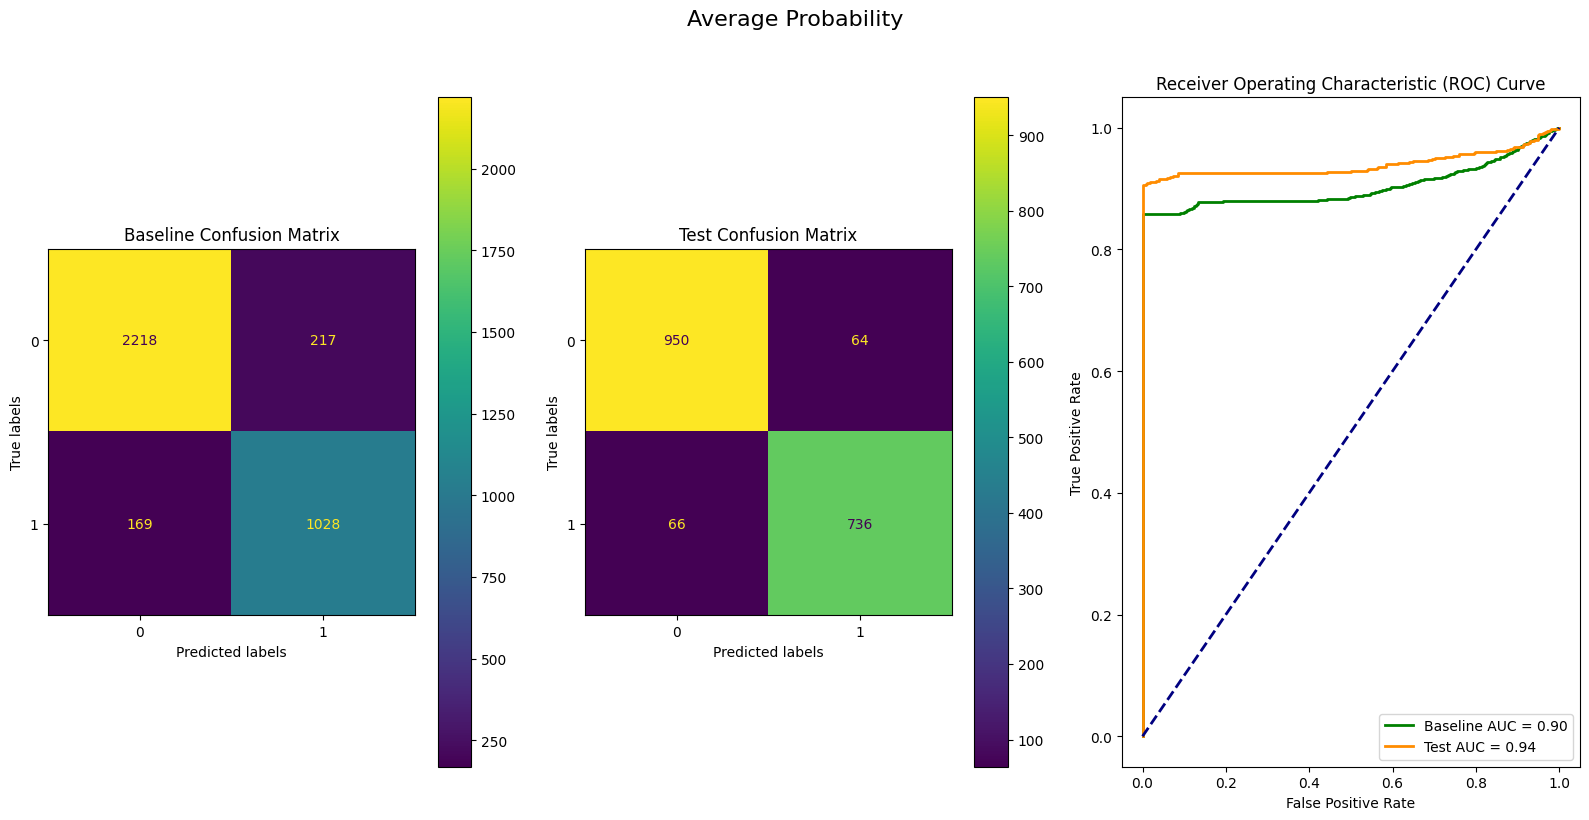

In [164]:
plot(baseline_metrics, test_metrics, title = 'Average Probability')

Baseline:
accuracy 0.86
f1 0.80
far 0.15
mar 0.12
thresholds [1.99995969e+00 9.99959686e-01 9.99949933e-01 9.99949293e-01
 9.99946692e-01 9.99946484e-01 9.99946203e-01 9.99946064e-01
 9.99945975e-01 9.99945856e-01 9.99945781e-01 9.99945691e-01
 9.99945615e-01 9.99944406e-01 9.99944390e-01 9.99943633e-01
 9.99943628e-01 9.99942411e-01 9.99942406e-01 9.99942322e-01
 9.99941976e-01 9.99941830e-01 9.99941524e-01 9.99941346e-01
 9.99941335e-01 9.99941169e-01 9.99941157e-01 9.99941108e-01
 9.99941017e-01 9.99938625e-01 9.99938304e-01 9.99938282e-01
 9.99937910e-01 9.99937847e-01 9.99937591e-01 9.99937499e-01
 9.99937497e-01 9.99937410e-01 9.99937362e-01 9.99937306e-01
 9.99936779e-01 9.99936692e-01 9.99934710e-01 9.99934656e-01
 9.99934020e-01 9.99933612e-01 9.99933266e-01 9.99933223e-01
 9.99933018e-01 9.99933006e-01 9.99932939e-01 9.99932873e-01
 9.99932818e-01 9.99932669e-01 9.99932657e-01 9.99932642e-01
 9.99932524e-01 9.99932496e-01 9.99932328e-01 9.99932291e-01
 9.99931761e-01 9.999315

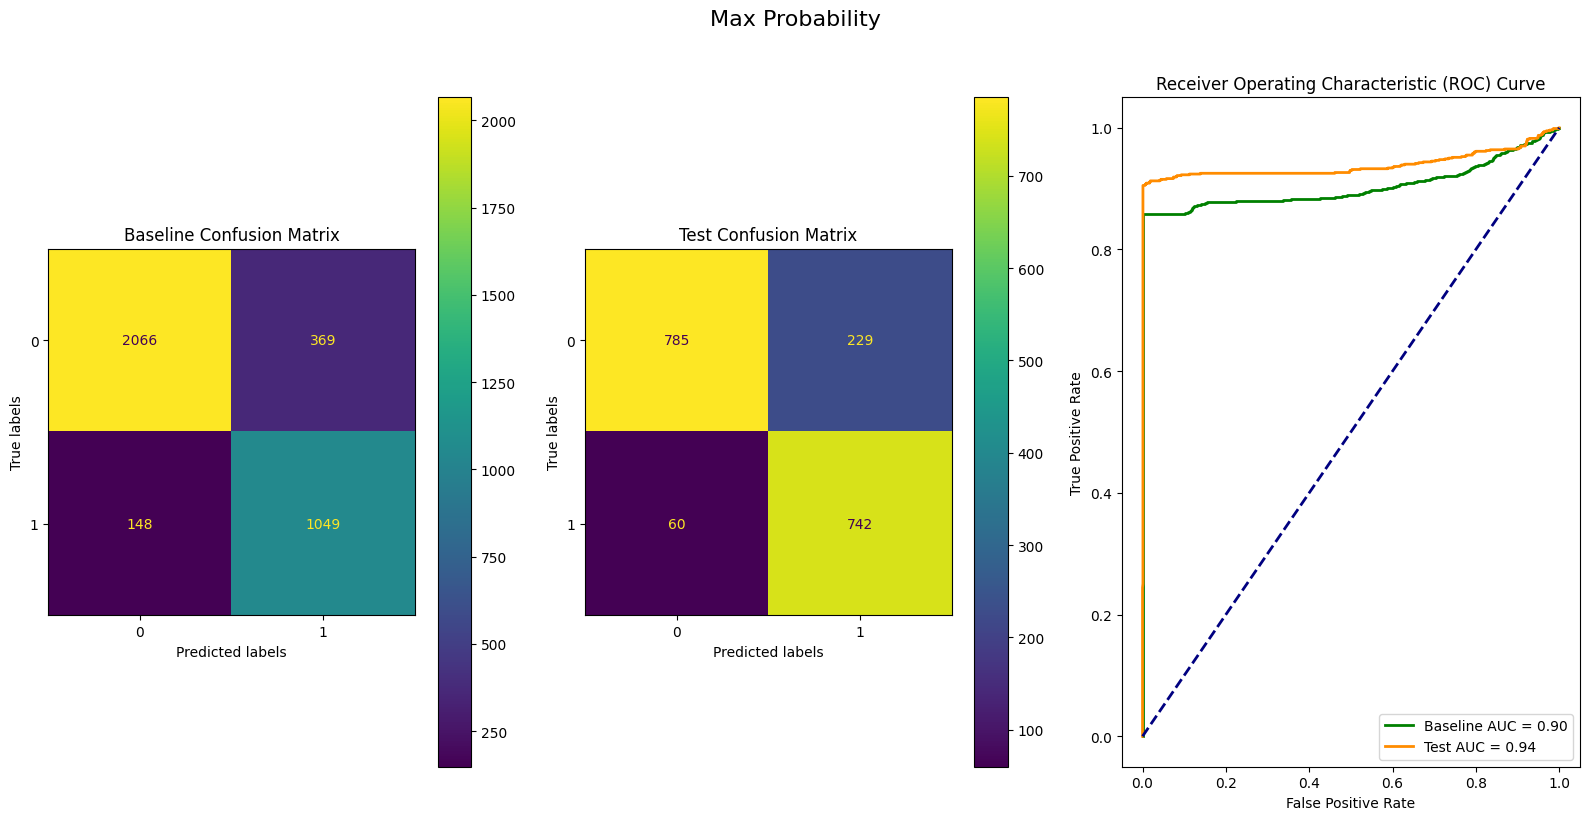

In [165]:
baseline_metrics = calc_metrics(y_valid,max_valid_predict)
print(f"Baseline:\naccuracy {baseline_metrics['accuracy']:.2f}\nf1 {baseline_metrics['f1']:.2f}\nfar {baseline_metrics['far']:.2f}\nmar {baseline_metrics['mar']:.2f}\nthresholds {baseline_metrics['thresholds']}")
test_metrics = calc_metrics(y_valid,max_test_predict)
print(f"Test:\naccuracy {test_metrics['accuracy']:.2f}\nf1 {test_metrics['f1']:.2f}\nfar {test_metrics['far']:.2f}\nmar {test_metrics['mar']:.2f}\nthresholds {test_metrics['thresholds']}")

plot(baseline_metrics, test_metrics, title = 'Max Probability')